In [1]:
# --- Step 1: Mount Google Drive (optional) ---
from google.colab import drive
drive.mount('/content/drive')  # Uncomment if dataset is in Google Drive

Mounted at /content/drive


In [2]:
import json
from datasets import Dataset

# Load your annotated dataset
with open("/content/drive/MyDrive/last_invoice/dataset/final_dataset.json", "r") as f:
    data = json.load(f)

# Inspect one example
print(data[0].keys())


dict_keys(['id', 'image', 'region_bboxes', 'region_labels', 'token_words', 'token_bboxes', 'token_labels'])


In [3]:
# Collect unique labels
unique_labels = sorted(set(l for entry in data for l in entry["token_labels"]))
label2id = {l: i for i, l in enumerate(unique_labels)}
id2label = {i: l for l, i in label2id.items()}

print(label2id)


{'B-customer_address': 0, 'B-customer_name': 1, 'B-due_date': 2, 'B-invoice_date': 3, 'B-invoice_number': 4, 'B-invoice_subtotal': 5, 'B-invoice_total': 6, 'B-item_description': 7, 'B-item_quantity': 8, 'B-item_total_price': 9, 'B-item_unit_price': 10, 'B-supplier_address': 11, 'B-supplier_name': 12, 'B-tax_amount': 13, 'B-tax_rate': 14, 'O': 15}


In [4]:
dataset = Dataset.from_list(data)

# Split train/valid if not already
dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [5]:
pip install transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=97c07f1965c0bbea970b245d6f2e2d2e80aa74a4d9986ad0d42d9b8f8d7866a4
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [6]:
from transformers import LayoutLMv3Processor

# Load the processor (adjust checkpoint if needed)
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

In [8]:
from PIL import Image
import torch

def tokenize_and_align_with_images(examples):
    # Load image
    image = Image.open(examples["image"]).convert("RGB")  # single image because batched=False

    # Use processor to tokenize + get pixel values, return tensors directly
    encoded_inputs = processor(
        images=image,  # Changed from 'image' to 'images'
        text=examples["token_words"],
        boxes=examples["token_bboxes"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"  # important
    )

    # Align labels
    word_ids = encoded_inputs.word_ids(batch_index=0)
    labels = []
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            if word_idx < len(examples["token_labels"]):
                labels.append(label2id[examples["token_labels"][word_idx]])
            else:
                labels.append(-100)
        else:
            labels.append(-100)
        previous_word_idx = word_idx

    # Convert labels to tensor
    encoded_inputs["labels"] = torch.tensor(labels, dtype=torch.long)

    # Clip bounding box values to be within [0, 1000]
    encoded_inputs["bbox"] = torch.clamp(encoded_inputs["bbox"], 0, 1000)


    # Return as dict
    return {
        "input_ids": encoded_inputs["input_ids"].squeeze(0),
        "attention_mask": encoded_inputs["attention_mask"].squeeze(0),
        "bbox": encoded_inputs["bbox"].squeeze(0),
        "labels": encoded_inputs["labels"],
        "pixel_values": encoded_inputs["pixel_values"].squeeze(0)
    }

# Apply mapping
train_dataset = dataset["train"].map(
    tokenize_and_align_with_images,
    batched=False,
    remove_columns=dataset["train"].column_names
)
train_dataset.set_format(type='torch')

test_dataset = dataset["test"].map(
    tokenize_and_align_with_images,
    batched=False,
    remove_columns=dataset["test"].column_names
)
test_dataset.set_format(type='torch')

Map:   0%|          | 0/973 [00:00<?, ? examples/s]

Map:   0%|          | 0/109 [00:00<?, ? examples/s]

In [30]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last 2 encoder layers (shared text + visual)
for layer in model.base_model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Unfreeze classifier head
for param in model.classifier.parameters():
    param.requires_grad = True


In [10]:
def is_valid(example):
    for (x0, y0, x1, y1) in example["bbox"]:
        if not (0 <= x0 <= 1000 and 0 <= y0 <= 1000 and 0 <= x1 <= 1000 and 0 <= y1 <= 1000):
            return False
    return True


In [11]:
# Count before filtering
train_before = len(train_dataset)
valid_before = len(test_dataset)

# Apply filtering
train_dataset = train_dataset.filter(is_valid)
test_dataset = test_dataset.filter(is_valid)

# Count after filtering
train_after = len(train_dataset)
valid_after = len(test_dataset)

print(f"Train dataset: removed {train_before - train_after} invalid samples")
print(f"Valid dataset: removed {valid_before - valid_after} invalid samples")


Filter:   0%|          | 0/973 [00:00<?, ? examples/s]

Filter:   0%|          | 0/109 [00:00<?, ? examples/s]

Train dataset: removed 0 invalid samples
Valid dataset: removed 0 invalid samples


In [12]:
for example in train_dataset:
    assert len(example["input_ids"]) == len(example["bbox"]), "Mismatch between tokens and boxes!"
    for box in example["bbox"]:
        assert all(0 <= v <= 1000 for v in box), f"Invalid bbox {box}"


In [13]:
num_labels = model.config.num_labels

def check_dataset(dataset, name="dataset"):
    print(f"Checking {name}...")
    for i, ex in enumerate(dataset):
        # Check bbox length
        if len(ex["input_ids"]) != len(ex["bbox"]):
            print(f"❌ Length mismatch in {name}[{i}] -> input_ids={len(ex['input_ids'])}, bbox={len(ex['bbox'])}")
            return i

        # Check bbox values
        for box in ex["bbox"]:
            if not all(0 <= v <= 1000 for v in box):
                print(f"❌ Invalid bbox in {name}[{i}] -> {box}")
                return i

        # Check labels
        if "labels" in ex:
            for lab in ex["labels"]:
                if lab != -100 and not (0 <= lab < num_labels):
                    print(f"❌ Invalid label in {name}[{i}] -> {lab}")
                    return i
    print(f"✅ {name} looks fine!")

check_dataset(train_dataset, "train")
check_dataset(test_dataset, "valid")


Checking train...
✅ train looks fine!
Checking valid...
✅ valid looks fine!


In [14]:
def check_alignment(dataset, name="dataset"):
    for i, ex in enumerate(dataset):
        n_ids = len(ex["input_ids"])
        n_bbox = len(ex["bbox"])
        n_labels = len(ex["labels"]) if "labels" in ex else n_ids

        if not (n_ids == n_bbox == n_labels):
            print(f"❌ Alignment issue in {name}[{i}] -> ids={n_ids}, bbox={n_bbox}, labels={n_labels}")
            return i
    print(f"✅ {name} alignment looks fine!")

check_alignment(train_dataset, "train")
check_alignment(test_dataset, "valid")


✅ train alignment looks fine!
✅ valid alignment looks fine!


In [15]:
# Inspect bbox ranges in the training dataset
all_bboxes = [item for sublist in train_dataset["bbox"] for item in sublist]
min_x = min([bbox[0] for bbox in all_bboxes])
min_y = min([bbox[1] for bbox in all_bboxes])
max_x = max([bbox[2] for bbox in all_bboxes])
max_y = max([bbox[3] for bbox in all_bboxes])

print(f"Min x: {min_x}, Min y: {min_y}, Max x: {max_x}, Max y: {max_y}")

Min x: 0, Min y: 0, Max x: 1000, Max y: 1000


In [16]:
from seqeval.metrics import precision_score, recall_score, f1_score
import numpy as np

# Assuming you have a list of label names in order of label IDs
# For example: id2label = {0: "O", 1: "B-PER", 2: "I-PER", ...}
id2label = {v: k for k, v in label2id.items()}  # Reverse your label2id dict

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = []
    true_predictions = []

    for pred_seq, label_seq in zip(predictions, labels):
        seq_true_labels = []
        seq_pred_labels = []
        for p_idx, l_idx in zip(pred_seq, label_seq):
            if l_idx != -100:  # ignore special tokens
                seq_true_labels.append(id2label[l_idx])
                seq_pred_labels.append(id2label[p_idx])
        true_labels.append(seq_true_labels)
        true_predictions.append(seq_pred_labels)

    precision = precision_score(true_labels, true_predictions)
    recall = recall_score(true_labels, true_predictions)
    f1 = f1_score(true_labels, true_predictions)

    return {"precision": precision, "recall": recall, "f1": f1}


In [17]:
from transformers import TrainingArguments, Trainer, LayoutLMv3Processor
import torch
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/last_invoice/visual_invoices",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,                          # Mixed precision
    dataloader_num_workers=2,           # Parallel data loading
    dataloader_pin_memory=True,         # Faster data transfer to GPU

    report_to=None,
)

# Fix the tokenizer warning by using processing_class
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=processor,  # Changed from tokenizer to processing_class
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [18]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: madunikarunarathne (mickykarunaratne) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.718650,0.692717,0.645198,0.668114
2,No log,0.552346,0.755921,0.717607,0.736266
3,0.875200,0.453246,0.819775,0.748857,0.782713
4,0.875200,0.365451,0.848086,0.810595,0.828917
5,0.484500,0.305558,0.859696,0.861662,0.860678
6,0.484500,0.282750,0.858355,0.886814,0.872352
7,0.350600,0.245326,0.894249,0.883003,0.888591
8,0.350600,0.227824,0.910547,0.888338,0.899306
9,0.281400,0.217024,0.901758,0.899009,0.900382
10,0.281400,0.212150,0.905901,0.895198,0.900518


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modelin

TrainOutput(global_step=2440, training_loss=0.45326203205546395, metrics={'train_runtime': 721.7031, 'train_samples_per_second': 13.482, 'train_steps_per_second': 3.381, 'total_flos': 2582739987824640.0, 'train_loss': 0.45326203205546395, 'epoch': 10.0})

In [19]:
trainer.save_model("/content/drive/MyDrive/last_invoice/layoutlmv3-finetuned-invoices03")
processor.save_pretrained("/content/drive/MyDrive/last_invoice/layoutlmv3-finetuned-invoices03")


[]

In [20]:
from google.colab import files
uploaded = files.upload()


Saving simple-invoice-template-light-blue-en.webp to simple-invoice-template-light-blue-en.webp


In [21]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 27.9 MB/s eta 0:00:00


In [22]:
import easyocr
from PIL import Image

In [23]:
reader = easyocr.Reader(['en'])   # add languages if needed

image_path = "/content/simple-invoice-template-light-blue-en.webp"   # replace with your uploaded file
ocr_result = reader.readtext(image_path)

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [24]:
img = Image.open(image_path)
w, h = img.size

words = []
boxes = []

for box, text, conf in ocr_result:
    if text.strip() == "":
        continue
    # box is 4 corner points; get min/max
    x_coords = [p[0] for p in box]
    y_coords = [p[1] for p in box]
    x1, y1, x2, y2 = min(x_coords), min(y_coords), max(x_coords), max(y_coords)

    # normalize to 0–1000
    norm_box = [
        int(1000 * x1 / w),
        int(1000 * y1 / h),
        int(1000 * x2 / w),
        int(1000 * y2 / h),
    ]

    words.append(text)
    boxes.append(norm_box)

print(words[:10])
print(boxes[:10])


['INVOICE', 'Company Name', '123 Address', 'Date:', '8/13/24', 'Anywhere; USA 54321', 'Invoice #', '7577', 'Phone: (555) 555-5555', 'PO #']
[[536, 47, 842, 104], [25, 148, 230, 178], [28, 192, 143, 210], [556, 189, 616, 207], [765, 189, 834, 207], [28, 219, 231, 239], [553, 219, 662, 237], [762, 219, 813, 239], [28, 246, 265, 269], [550, 244, 613, 267]]


In [25]:
from transformers import LayoutLMv3TokenizerFast

# Load tokenizer
tokenizer = LayoutLMv3TokenizerFast.from_pretrained(
    "/content/drive/MyDrive/last_invoice/layoutlmv3-finetuned-invoices03"
)

# Prepare inputs
encoding = tokenizer(
    words,
    boxes=boxes,
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=512,

)

# Run inference with model directly
from transformers import LayoutLMv3ForTokenClassification
import torch

model = LayoutLMv3ForTokenClassification.from_pretrained(
    "/content/drive/MyDrive/last_invoice/layoutlmv3-finetuned-invoices03"
)

with torch.no_grad():
    outputs = model(**encoding)

# Get predictions
logits = outputs.logits
pred_ids = logits.argmax(-1).squeeze().tolist()

# Map back to labels
id2label = model.config.id2label
pred_labels = [id2label[p] for p in pred_ids]

print(pred_labels[:30])


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-due_date', 'B-due_date', 'B-due_date', 'B-due_date', 'B-due_date', 'B-customer_address', 'B-customer_address', 'B-customer_address', 'B-customer_address', 'B-customer_address', 'B-customer_address', 'O', 'O', 'O', 'O', 'B-invoice_number', 'O', 'O', 'O', 'O']


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


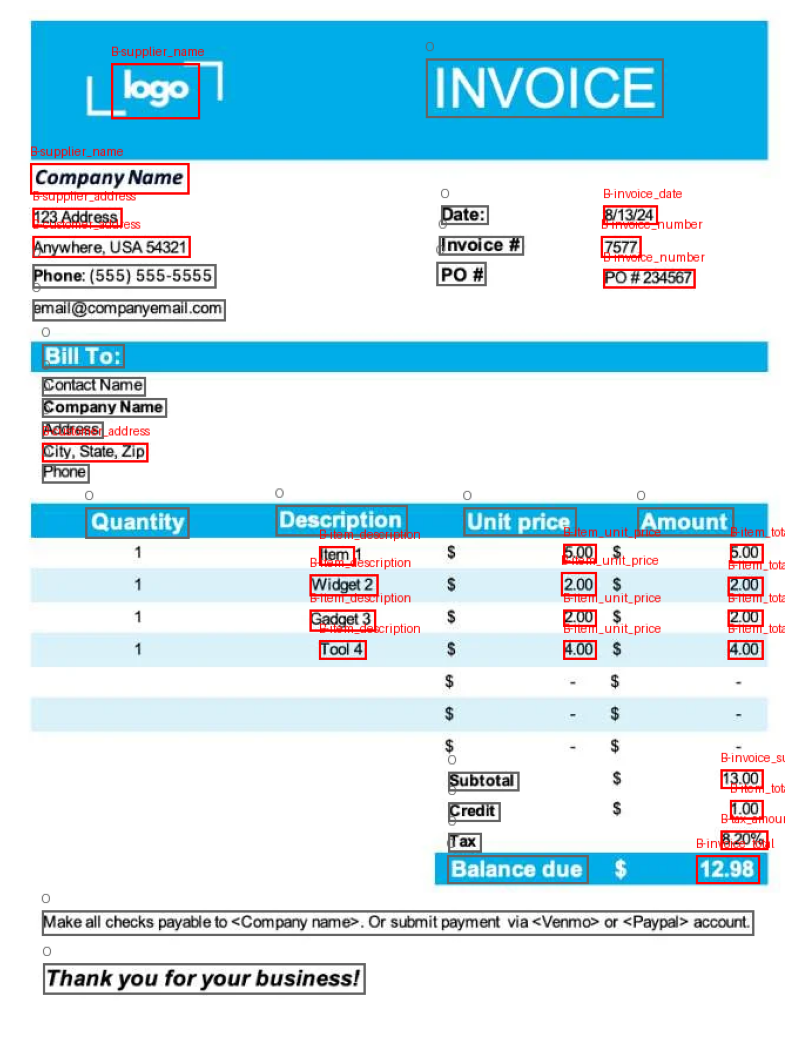

{'B-supplier_name': ['kogo', 'Company Name'],
 'O': ['INVOICE',
  'Date:',
  'Invoice #',
  'Phone: (555) 555-5555',
  'PO #',
  'email@companyemall com',
  'Bill To;',
  'Contact Name',
  'Company Name',
  'Address',
  'Phone',
  'Quantity',
  'Description',
  'Unit price',
  'Amount',
  'Subtotal',
  'Credit',
  'Tax',
  'Balance due',
  'Make all checks payable to <Company name> . Or submit payment via < Venmo> or <Paypal> account',
  'Thank you for your businessl'],
 'B-supplier_address': ['123 Address'],
 'B-invoice_date': ['8/13/24'],
 'B-customer_address': ['Anywhere; USA 54321', 'City, State, Zip'],
 'B-invoice_number': ['7577', 'PO #234557'],
 'B-item_description': ['Item', 'Widget 2', 'Gadget 3', 'Tool 4'],
 'B-item_unit_price': ['5.00', '2.00', '2.00', '4.00'],
 'B-item_total_price': ['5.00', '2.00', '200', '4.00', '1.00'],
 'B-invoice_subtotal': ['13.00'],
 'B-tax_amount': ['8.20%'],
 'B-invoice_total': ['12.98']}

In [27]:
# 1) Install deps (Colab)
!pip -q install easyocr transformers>=4.37 pillow matplotlib

import math
import numpy as np
import torch
import easyocr
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification

# ---- CONFIG ----
IMAGE_PATH = "/content/simple-invoice-template-light-blue-en.webp"  # your uploaded photo
MODEL_DIR  = "/content/drive/MyDrive/last_invoice/layoutlmv3-finetuned-invoices03"  # your fine-tuned model folder
LANGS = ['en']  # add more langs if needed, e.g., ['en','es']
CONF_THRESH = 0.35  # drop very low confidence OCR boxes

# Optional: category colors for nicer viz
COLOR_MAP = {
    "customer_address": (255, 0, 0),
    "customer_name": (255, 165, 0),
    "due_date": (0, 128, 0),
    "invoice_date": (0, 0, 255),
    "invoice_number": (138, 43, 226),
    "invoice_subtotal": (220, 20, 60),
    "invoice_total": (0, 128, 128),
    "item_description": (30, 144, 255),
    "item_quantity": (255, 0, 255), # Magenta
    "item_total_price": (128, 0, 0), # Dark Red
    "item_unit_price": (0, 128, 0), # Green
    "supplier_address": (128, 128, 0), # Olive
    "supplier_name": (0, 128, 128), # Teal
    "tax_amount": (128, 0, 128), # Purple
    "tax_rate": (0, 0, 128), # Navy
    "O": (100, 100, 100), # Grey
}


# 2) OCR with EasyOCR
reader = easyocr.Reader(LANGS)
raw = reader.readtext(IMAGE_PATH)  # each: [poly, text, conf]
img = Image.open(IMAGE_PATH).convert("RGB")
W, H = img.size

# 3) Convert polys -> boxes, filter, and collect (x1,y1,x2,y2) in pixels
tmp = []
for poly, text, conf in raw:
    if not text or conf < CONF_THRESH:
        continue
    xs = [p[0] for p in poly]
    ys = [p[1] for p in poly]
    x1, y1, x2, y2 = max(0, min(xs)), max(0, min(ys)), min(W, max(xs)), min(H, max(ys))
    tmp.append((text, [x1, y1, x2, y2]))

# 4) Sort into reading order (line-wise by y-center, then x)
def reading_order(entries, y_tol=0.015):
    # entries: list of (text, [x1,y1,x2,y2])
    # group by approximate line using y-center tolerance
    lines = {}
    for t, (x1,y1,x2,y2) in entries:
        yc = (y1+y2)/2
        placed = False
        for k in list(lines.keys()):
            if abs(k - yc) <= y_tol*H:
                lines[k].append((t, [x1,y1,x2,y2]))
                placed = True
                break
        if not placed:
            lines[yc] = [(t, [x1,y1,x2,y2])]
    # sort lines by y, and words in line by x
    ordered = []
    for k in sorted(lines.keys()):
        line = sorted(lines[k], key=lambda e: e[1][0])
        ordered.extend(line)
    return ordered

ordered = reading_order(tmp)

# 5) Build words + normalized boxes for processor (0..1000 int, clamped)
words = []
boxes = []
for t, (x1, y1, x2, y2) in ordered:
    b = [
        int(1000 * x1 / W),
        int(1000 * y1 / H),
        int(1000 * x2 / W),
        int(1000 * y2 / H),
    ]
    # clamp strictly into [0,1000]
    b = [min(1000, max(0, v)) for v in b]
    words.append(t)
    boxes.append(b)

if len(words) == 0:
    raise ValueError("No OCR words after filtering. Lower CONF_THRESH or check the image.")

# 6) Processor + model (pass image + words + boxes)
processor = LayoutLMv3Processor.from_pretrained(MODEL_DIR, apply_ocr=False)
model = LayoutLMv3ForTokenClassification.from_pretrained(MODEL_DIR)
id2label = model.config.id2label

encoding = processor(
    images=img,
    text=words,
    boxes=boxes,
    truncation=True,
    padding="max_length",
    max_length=512,
    return_tensors="pt"
)

with torch.no_grad():
    outputs = model(**encoding)

logits = outputs.logits  # [1, seq_len, num_labels]
pred_ids = logits.argmax(-1).squeeze(0).tolist()

# 7) Convert token-level preds -> word-level preds using word_ids
word_ids = encoding.word_ids(batch_index=0)  # list length = seq_len
word_level_labels = []
used = set()
for tok_idx, widx in enumerate(word_ids):
    if widx is None or widx in used:
        continue
    used.add(widx)
    word_level_labels.append(id2label[pred_ids[tok_idx]])

# Sanity: align lengths
word_level_labels = word_level_labels[:len(words)]
assert len(word_level_labels) == len(words), f"Mismatch: {len(word_level_labels)} vs {len(words)}"

# 8) Draw colored boxes + labels back on the image
draw = ImageDraw.Draw(img)
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 16)
except:
    font = ImageFont.load_default()

for (t, (x1,y1,x2,y2)), label in zip(ordered, word_level_labels):
    color = COLOR_MAP.get(label, (255, 0, 0))
    draw.rectangle([x1, y1, x2, y2], width=2, outline=color)
    ty = max(0, y1 - 16)
    draw.text((x1, ty), label, fill=color, font=font)

plt.figure(figsize=(10,14))
plt.imshow(img)
plt.axis("off")
plt.show()

# 9) (Optional) build a quick structured dict by label buckets
structured = {}
for w, lab in zip(words, word_level_labels):
    structured.setdefault(lab, []).append(w)

structured

# Loging per 50 steps

In [32]:
from transformers import TrainingArguments, Trainer, LayoutLMv3Processor
import torch
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/last_invoice/visual_invoices",
    logging_strategy="steps",   # instead of epoch
    logging_steps=50,           # or smaller
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    push_to_hub=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,                          # Mixed precision
    dataloader_num_workers=2,           # Parallel data loading
    dataloader_pin_memory=True,         # Faster data transfer to GPU

    report_to=None,
)

# Fix the tokenizer warning by using processing_class
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    processing_class=processor,  # Changed from tokenizer to processing_class
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [33]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.832900,0.709438,0.718422,0.652439,0.683843
2,0.614400,0.532165,0.773998,0.728277,0.750442
3,0.507100,0.428527,0.820503,0.783918,0.801793
4,0.436700,0.358647,0.858052,0.822409,0.839852
5,0.381500,0.310424,0.862519,0.855945,0.859220
6,0.332800,0.283417,0.864855,0.873095,0.868955
7,0.290900,0.254620,0.893692,0.874619,0.884052
8,0.298800,0.234996,0.899883,0.880335,0.890002
9,0.252600,0.228723,0.899228,0.887576,0.893364
10,0.249900,0.225367,0.903727,0.887195,0.895385


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:1742: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/modelin

TrainOutput(global_step=2440, training_loss=0.4513027542927226, metrics={'train_runtime': 738.0069, 'train_samples_per_second': 13.184, 'train_steps_per_second': 3.306, 'total_flos': 2582739987824640.0, 'train_loss': 0.4513027542927226, 'epoch': 10.0})